In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_dir = '/content/drive/MyDrive/Guava Disease Dataset/train'
test_dir = '/content/drive/MyDrive/Guava Disease Dataset/test'
valid_dir = '/content/drive/MyDrive/Guava Disease Dataset/val'

In [4]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

valid_datasets = tf.keras.preprocessing.image_dataset_from_directory(
    directory = valid_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = valid_datasets.class_names
valid_data = valid_datasets.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1194 files belonging to 5 classes.
Found 394 files belonging to 5 classes.
Found 336 files belonging to 5 classes.


In [5]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),  # Removed 'experimental.preprocessing'
  tf.keras.layers.RandomRotation(0.2),  # Removed 'experimental.preprocessing'
  tf.keras.layers.RandomZoom(0.2),  # Removed 'experimental.preprocessing'
  tf.keras.layers.RandomHeight(0.2),  # Removed 'experimental.preprocessing'
  tf.keras.layers.RandomWidth(0.2),  # Removed 'experimental.preprocessing'
  tf.keras.layers.Rescaling(1./255)  # Removed 'experimental.preprocessing'
], name ="data_augmentation")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


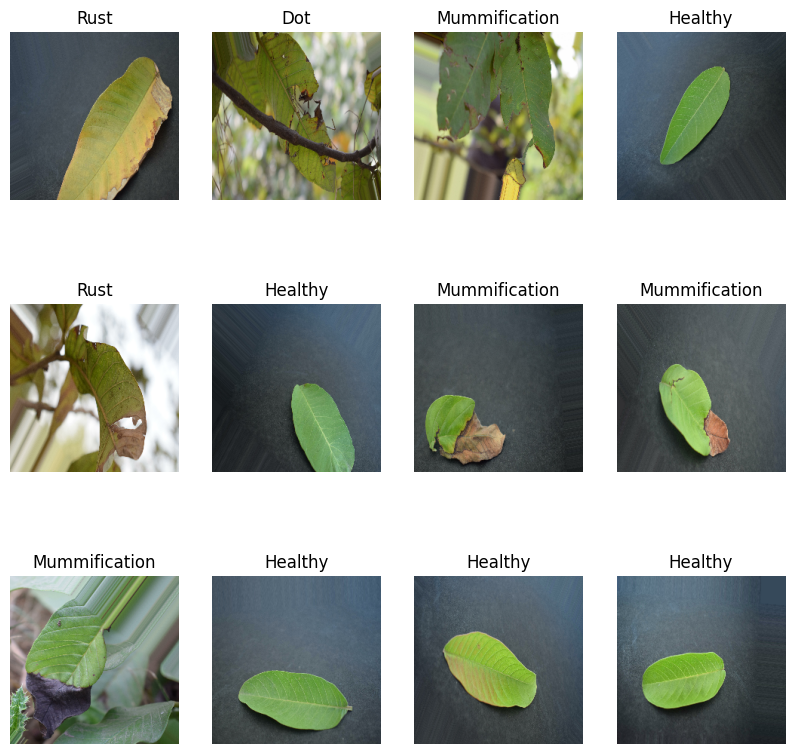

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

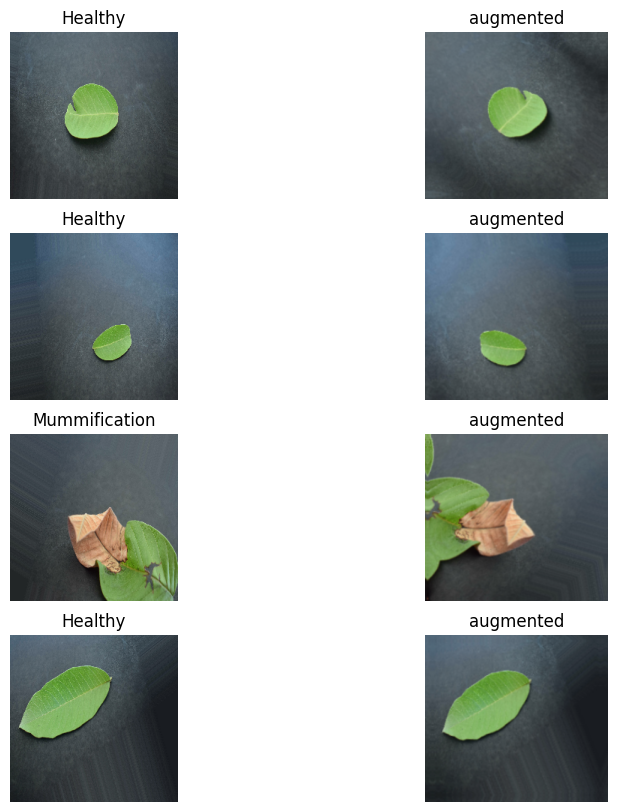

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        plt.imshow(augmented_image_batch[i])
        plt.title(f"augmented")
        plt.axis("off")

In [8]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=CheckPoint/cp.ckpt

In [ ]:
input_shape = (32, 224, 224, 3)
model = tf.keras.models.Sequential(
    [
        data_augmentation,
        tf.keras.layers.Conv2D(
          filters=64,
          kernel_size=3,
          activation='relu',
          input_shape=input_shape
        ),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(
          pool_size=2,
          padding='valid'
        ),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ]
)
model.build(input_shape=input_shape)

In [ ]:
model.summary()

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback,
    ]
)

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [ ]:
plot_loss_curves(history)

In [ ]:
def bestWeightModelEvaluate(model, weight_path, data):
  cp_model = tf.keras.models.clone_model(model)
  cp_model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )
  cp_model.load_weights(weight_path)
  cp_model.evaluate(data)

In [ ]:
# Train data
model.evaluate(train_data)
# Test data
model.evaluate(test_data)
# Valid data
model.evaluate(valid_data)

In [ ]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = test_data
)

In [ ]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = valid_data
)

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")